# 2016 US Bikeshare Analysis

------


## 1.0 Posing Questions

### 1.1 General Questions
1. Which stations are the most popular?
2. On what days and times do people use the bikeshares the most?
3. How does use change depending on holidays?
4. Is bikeshare use similar across cities?

### 1.2 Business Questions
1. How many bikes should each bikeshare have available?
2. What is the optimal driving time between bikeshare stations?

## 2.0 Data Collection and Wrangling

### 2.1 Previewing The Data

As with all data analysis, it's a good idea to know the data a little bit such as what columns exist, what data exists inside these columns and if there is missing data.

In [304]:
# Importing packages and functions
import csv # reading and writing to CSV files
import datetime # operations to parse dates
from pprint import pprint # use to print data structures like dictionaries in
                          # a nicer way than the base print function.
import pandas as pd # converts CSV files into dataframes which are more practical to use than plain text
import numpy as np # performs calculations
from ggplot import * # I know we're not supposed to do this but there was no other way.

In [305]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    # Read the first from from the dataf file and store it in a variable
    with open(filename, 'r') as f_in:
        
        # Use the csv library to set up a DictReader object.
        trip_reader = csv.DictReader(f_in)
        
        #  Use a function on the DictReader object to read the
        #  first trip from the data file and store it in a variable.
        first_trip = next(trip_reader)
        
        #  Use the pprint library to print the first trip. 
        pprint(first_trip)
        
    # output city name and first trip for later testing
    return (city, first_trip)

# list of files for each city
data_files = ['./data/NYC-CitiBike-2016.csv',
              './data/Chicago-Divvy-2016.csv',
              './data/Washington-CapitalBikeshare-2016.csv',]

# print the first trip from each file, store in dictionary to check the code works
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip


City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar

It seems that the data contains information such as travel duration, the dates on which this travel occured, the starting and ending points, the bike ID and some information over the consumer.

This data is not entirely homogenous between the CSV files. Hence, the columns will need to be transformed so that they become homogenous.

It is also possible to see that the NYC data already has a missing value on "birth year" which can be iputed later or the row itself can be dropped entirely. Other than that, the quality of the data is very high which is good news! 

### 2.2 Condensing the Data

As mentioned above, it is important so that the data becomes homogenous across datasets. This is going to be addressed in this section.

This is going to be done by creating functions that converts the different values in the column into a homogneous form.

In [306]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes.
    """
    
    # Look up trip duration
    if city == 'NYC':
        duration = int(datum['tripduration'])
        
    elif city == 'Chicago':
        duration = int(datum['tripduration'])
        
    else:
        duration = int(datum['Duration (ms)'])/1000 # Original data is in ms
    
    return duration/60

In [312]:
def date_string_to_weekday(date):
    """
    Takes date as a string in the form 'mm/dd/yyyy' and converts it
    to a week day
    """
    
    #dictionary to convert weekday number to day of week
    weekday_dictionary = {0: "Monday",
                          1: "Tuesday",
                          2: "Wednesday",
                          3: "Thursday",
                          4: "Friday",
                          5: "Saturday",
                          6: "Sunday"}
    
    
    
    #find weekday number
    month, day, year = date.split('/')
    week_day = datetime.datetime.weekday(datetime.date(int(year), int(month), int(day)))
    
    
    return weekday_dictionary[week_day]

def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    """

    if city == 'NYC':
        
        # extract month
        month =  datum['starttime'].split('/')[0]
        
        # extract hour
        hour = datum['starttime'].split()[1].split(':')[0]
        
        # get day of week
        day_of_week = date_string_to_weekday(datum['starttime'].split()[0])
        
    elif city == 'Chicago':
        
        # extract month
        month =  datum['starttime'].split('/')[0]
        
        # extract hour
        hour = datum['starttime'].split()[1].split(':')[0]
        
        # get day of week
        day_of_week = date_string_to_weekday(datum['starttime'].split()[0])
        
    else:
     
        # extract month
        month =  datum['Start date'].split('/')[0]
        
        # extract hour
        hour = datum['Start date'].split()[1].split(':')[0]
        
        # get day of week
        day_of_week = date_string_to_weekday(datum['Start date'].split()[0])
    
    return (int(month), int(hour), day_of_week)

In [313]:
def correct_member_type(user_type):
    """
    Converts the user type for the Washington dataset so that it fits the other
    datasets.
    """
    # Dictionary for the conversion
    user_type_dictionary = {"Registered":"Subscriber",
                            "Casual":"Customer"}
    
    # Converting member type
    new_user_type = user_type_dictionary[user_type]
        
    return new_user_type


def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    """
    
    if city == 'NYC': user_type = datum['usertype']
    elif city == 'Chicago': user_type = datum['usertype']
    else: user_type = correct_member_type(datum['Member Type'])
     
        
    
    return user_type

Now that all of the functions have been defined to condense the CSV files into the form as seen in ./examples, the next code will do just that

In [314]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    
    HINT: See the cell below to see how the arguments are structured!
    """
    
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        # Set up csv DictWriter object - writer requires column names for the
        # First row as the "fieldnames" argument
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        trip_reader = csv.DictReader(f_in)
        
        #  Use a function on the DictReader object to read the
        #  first trip from the data file and store it in a variable.
        first_trip = next(trip_reader)
        

        """
        Variables I am working with because this function is a mess:
            out_colnames
        """
        
        # Collect data from and process each row
        for row in trip_reader:
            # Set up a dictionary to hold the values for the cleaned and trimmed
            # data points
            new_point = {}
            month, hour, day_of_week = time_of_trip(row, city)
            new_point[out_colnames[0]] = duration_in_mins(row, city)
            new_point[out_colnames[1]] = month
            new_point[out_colnames[2]] = hour
            new_point[out_colnames[3]] = day_of_week
            new_point[out_colnames[4]] = type_of_user(row, city)
            
            # Write row to new csv file
            trip_writer.writerow(new_point)
            

In [315]:
# Run this cell to check your work
city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}

for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '9.792516666666668'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: Chicago
OrderedDict([('duration', '3.3'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '11.433333333333334'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Subscriber')])


Awesome! That was confusing to write but it seems to work well once you put everything together. Now for the fun part!

## 3.0 Exploratory Data Analysis

Now that the data has been munged, it is time to explore the data a little bit.

I am going to be using Pandas instead of CSV from this point forward because I've demonstrated that I am able to use CSV. However, Pandas is clearly the superior library when it comes to handling data. 

I'll also be using ggplot instead of matplotlib because I want to explore using different packages. I'm a big fan of ggplot2 when using R which is why I'm curious to see how it works in Python.

### 3.1 Statistics - Number of Trips

Firstly I want to investigate the following questions:

* Which city has the highest number of trips? 
* Which city has the highest proportion of trips made by subscribers? 
* Which city has the highest proportion of trips made by short-term customers?

This means that a function that counts the number of trips will have to be written

In [316]:
def number_of_trips(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    
    # Create dataframe
    df = pd.read_csv(filename)
    
    # initialize count variables
    n_subscribers = len(df[df['user_type']=='Subscriber'])
    n_customers = len(df[df['user_type']=='Customer'])
    
    # compute total number of rides
    n_total = n_subscribers + n_customers

    # return tallies as a tuple
    return(n_subscribers, n_customers, n_total)

If you compare this cell to the corresponding one in Bike_Share_Analysis.ipynb, you'll see why I'm opting to use Pandas instead. It's much less of a headache to deal with.

In [317]:
## Modify this and the previous cell to answer Question 4a. Remember to run ##
## the function on the cleaned data files you created from Question 3.      ##

filepaths = ['./data/NYC-2016-Summary.csv', './data/Chicago-2016-Summary.csv', './data/Washington-2016-Summary.csv']


for path in filepaths:
    print(path,": \n")
    n_subscribers, n_customers, n_total = number_of_trips(path)
    print("n_subscribers: ", n_subscribers)
    print("n_customers: ", n_customers)
    print("n_total: ", n_total)
    print("proportion subscribers: ", n_subscribers/n_total)
    print("proportion customers: ", n_customers/n_total)
    print("\n")
    

./data/NYC-2016-Summary.csv : 

n_subscribers:  245896
n_customers:  30184
n_total:  276080
proportion subscribers:  0.8906693711967546
proportion customers:  0.10933062880324544


./data/Chicago-2016-Summary.csv : 

n_subscribers:  54981
n_customers:  17149
n_total:  72130
proportion subscribers:  0.7622487175932344
proportion customers:  0.23775128240676557


./data/Washington-2016-Summary.csv : 

n_subscribers:  51752
n_customers:  14573
n_total:  66325
proportion subscribers:  0.780278929513758
proportion customers:  0.21972107048624198




Hence, NYC has the highest number of trips with there being more than Chicago and Washington combined. Of the three cities, NYC has the highest proportion of subscribers while Chicago has the highest proportion of customers.

Although Chicago has the lowest subscriber rate, it does not have the lowest number of users which suggests that the proportion of subscriptions may not be correlated with the total number of clients.

It should also be noted that Chicago and Washington seem to have consistent values where as NYC seems to have a much larger market for Bikesharing. NYC's large market may be due to larger population, which can be confirmed/rejected by controlling the number of subscribers or total_users by the population of each city. If the posited hypothesis is rejected then it could alternatively be due to population density and/or the rate of congestion within the city encouraging people to use flexible forms of transportation (relative to cars) over short distances.

It is important not to confuse the difference between *proportion* and *absolute* number of subscribers. It should be expected that absolute number of subscribers should climb with population, whether this trend is linear of exponential (perhaps due to network effects) is something that could also be investigated.

### 3.2 Statistics - Travel Time Stats

Next, I want to take a look at these questions:

* What is the average trip length for each city? 
* What proportion of rides made in each city are longer than 30 minutes?

In [318]:
def travel_time_stats(filename):
    """
    This function calculates the average travel time of the CSV summaries.
    Input is the file path and the returned value is a float.
    """
    
    # Create dataframe
    df = pd.read_csv(filename)
    
    # Calculate average
    average = np.average(df['duration'])
    
    # Calculate proportion of rides above 30 mins
    proportion = len(df[df['duration']>30])/len(df)

    return average, proportion

Now that the function to calculate the average travel time is complete, let's have a look at what the values are.

In [319]:
## Modify this and the previous cell to answer Question 4b. ##

filepaths = ['./data/NYC-2016-Summary.csv', './data/Chicago-2016-Summary.csv', './data/Washington-2016-Summary.csv']

# Display the data created by population_overtime function
for path in filepaths:    
    average_travel, proportion_overtime = travel_time_stats(path)
    print(path,": \n")
    print("average travel time (min): ", average_travel)
    print("proportion over 30 mins: ", proportion_overtime)
    print("\n")
    

./data/NYC-2016-Summary.csv : 

average travel time (min):  15.8125996067
proportion over 30 mins:  0.07302463538260892


./data/Chicago-2016-Summary.csv : 

average travel time (min):  16.563645039
proportion over 30 mins:  0.08332178011922917


./data/Washington-2016-Summary.csv : 

average travel time (min):  18.933051618
proportion over 30 mins:  0.10839050131926121




The above data seems to strongly suggest that points of interest that people want to commonly travel between are further apart in Washington than in NYC. Although, it would still be interesting to visualise the data using a histogram to more intuitively gain a grasp for the spread of the data and whether there is a skew for longer or shorter journeys.

The data above can be used to gain a vague picture of what these histograms would look like, where the averages are a measure of central tendency and the proportion of rides over 30 minutes long is a proxy for the spread of the data.

### 3.3 Statistics - Proportion Overtime

Next, I would like to look deeper into which type of user takes longer rides on average within Washington. 
* There are a significant number of people who are taking longer rides, but is this because of a many "one off" events?

In [320]:
def proportion_overtime(filename):
    """
    This function calculates the proportion of subscribers relative to total clients' travel time
    where the duration of the trip is higher than 30 of the CSV summaries.
    Input is the file path and the returned value is a float.
    """
    
    # Create dataframe
    df = pd.read_csv(filename)
    
    # Filter dataframe to contain longer rides
    df2 = df[df['duration']>30]
    
    # Calculate proportion subscribers and customer
    p_customer = len(df2[df2['user_type'] == 'Customer'])/len(df2)
    p_subscriber = len(df2[df2['user_type'] == 'Subscriber'])/len(df2)

    return p_customer, p_subscriber

And now to look at the results:

In [321]:
## Modify this and the previous cell to answer Question 4c. ##

filepaths = ['./data/NYC-2016-Summary.csv', './data/Chicago-2016-Summary.csv', './data/Washington-2016-Summary.csv']

# Display the data created by porportion_overtime function
for path in filepaths: 
    if path != filepaths[2]: continue # Remove this line to see proportions for each city
    p_customer, p_subscriber = proportion_overtime(path)
    print(path,": \n")
    print("Proportion Customers: ", p_customer)
    print("Proportion Subscribers: ", p_subscriber)
    print("\n")
    

./data/Washington-2016-Summary.csv : 

Proportion Customers:  0.7907914869940187
Proportion Subscribers:  0.20920851300598137




This result makes sense because if one was to take a long journey regularly then one would either plan to use some form of public transportation, buy a car or buy their own bike. (Although there are still reasons why you would want a subscription over having your own bike, the customer would not need to worry about storage, security and maintainance for example.)

After quickly checking the values for all cities, it would seem that a large proportion of subscribers travel distances longer than 30 minutes relative to Chicago and Washington. This suggests that there is something exceptional about NYC which causes it to follow different trends from other cities.

## 4.0 Visualisations & Own Analysis

As mentioned above, it would be interesting to see a histograph showing the distribution of trip durations. We'll tackle that using ggplot below. (The package was imported at the start of this notebook)

In [331]:
def convert_weekdays(df, week_days):
    """
    This function converts the weekdays into numbers so that
    they don't get sorted by alphabetical order in ggplot
    """
    
    
    # Replace weekdays w/ numbers
    for i in week_days.keys():
        df[df['day_of_week']==i] = week_days[i]
    
    return df
    

In [424]:
def create_histogram(filename, column='duration', ylabel, n_bins=100, facet=False, x_facet='month', y_facet='user_type', x_axis_limit=350):

    # Import the dataframe
    df = pd.read_csv(filename)
    
    # Create plot
    if not facet:
        %matplotlib inline
        plot = ggplot(aes(x=column, data=df) +\
        geom_histogram(bins=n_bins, colour='black', fill='darkblue', alpha=.7) +\
        xlab(column) + ylab('frequency')+\
        ggtitle("Distribution of travel duration")
        plot.show()
    
    # Facets
    else:
        %matplotlib inline
        plot = ggplot(aes(x=column), data=df2) +\
        geom_histogram(bins=(5/75), color='black', fill='darkblue', alpha=.4) +\
        xlab("Duration (minutes)") + ylab("Frequency")+\
        ggtitle("Distribution of travel duration")+\
        xlim(0, 75)+\
        facet_grid(x_facet, y_facet)
        plot.show()

SyntaxError: invalid syntax (<ipython-input-424-d2c5b1e1249a>, line 10)

### 4.1 - Histogram of travel duration frequency

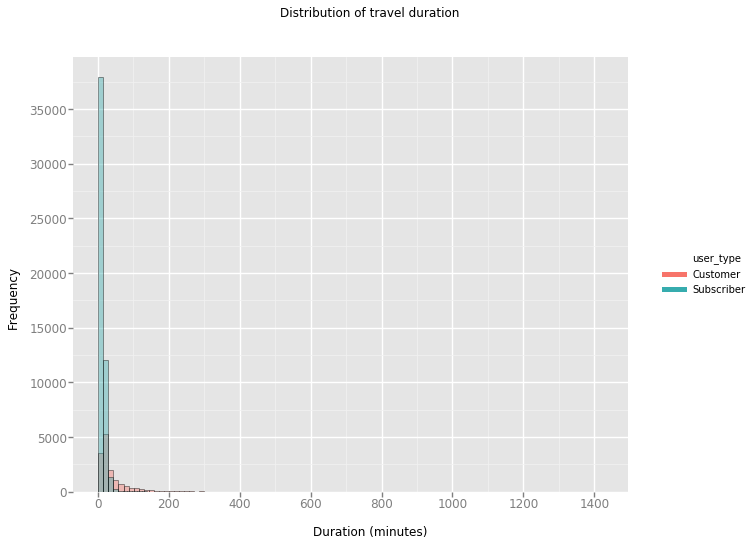

In [423]:
create_histogram('./data/Washington-2016-Summary.csv')

This plot stuck me as incredibly weird at first because the default value should end around 350 minutes. After looking at the data it would seem that there are some people who rent bikes for hours at a time even if the vast majority of customers seem to use it for 1 hour (max).

From the visualisation it is also possible to see that customers tend to use the bikeshare service to travel for longer durations than subscribers do, who mostly seem to use it for short jouneys. This might be because subscribers have "favorite" routes that factor into their commutes

In [324]:
df_temp = pd.read_csv('./data/Washington-2016-Summary.csv')
df_temp = df_temp[df_temp['duration']>1000]
print(df_temp)

          duration  month  hour day_of_week   user_type
2367   1345.946817      3    19      Sunday  Subscriber
2851   1211.217517      3    12    Thursday    Customer
11124  1422.516367      4    12    Saturday    Customer
13382  1356.763333      4    12    Saturday    Customer
14618  1016.912800      4    15    Thursday  Subscriber
15074  1398.560083      4    19    Saturday    Customer
16059  1002.115767      4    17    Thursday  Subscriber
16425  1227.867650      4    17    Saturday    Customer
16442  1139.228950      4    19    Saturday    Customer
16784  1222.949217      5    11     Tuesday    Customer
17237  1169.998750      5    19    Thursday    Customer
18063  1026.322033      5    17     Tuesday    Customer
18434  1217.283083      5    18    Thursday  Subscriber
21284  1291.166833      5    16      Friday  Subscriber
21551  1220.835583      5    18    Saturday  Subscriber
25430  1373.064333      6     9     Tuesday  Subscriber
27646  1174.254200      6     9    Thursday  Sub

### 4.2 Faceting travel duration by by hour, month and day

#### Faceting by Month

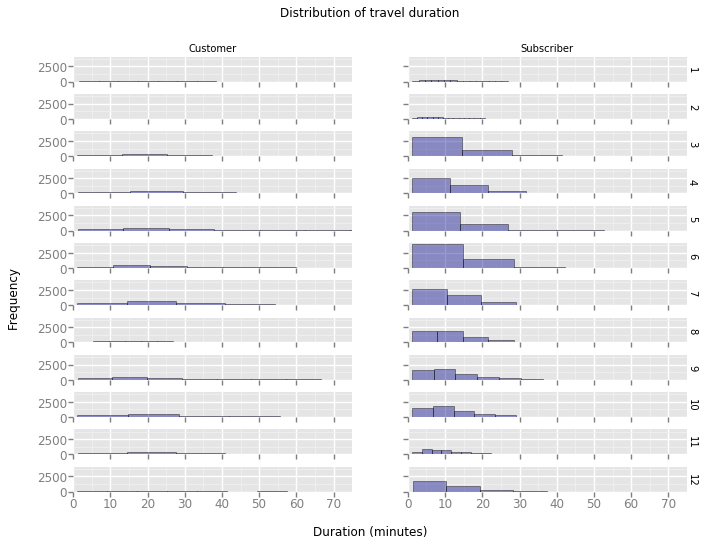

In [347]:
create_histogram('./data/Washington-2016-Summary.csv', facet=True, x_facet='month', y_facet='user_type', x_axis_limit=75)

#### Faceting by Hour

The above plot suggests that subscribers tend to use the bikeshare at different points of time. Spring/Summer (3-7) seems the time when subscribers tend to use the bikeshare service the most, although there are many people who like to use the bike during december. These times coincide strongly with times when people are taking vacations. (Perhaps customers are in school/university?)

Customers, on the other hand, tend to use the bikeshare service all year around for sporadic trips that may take longer than usual.

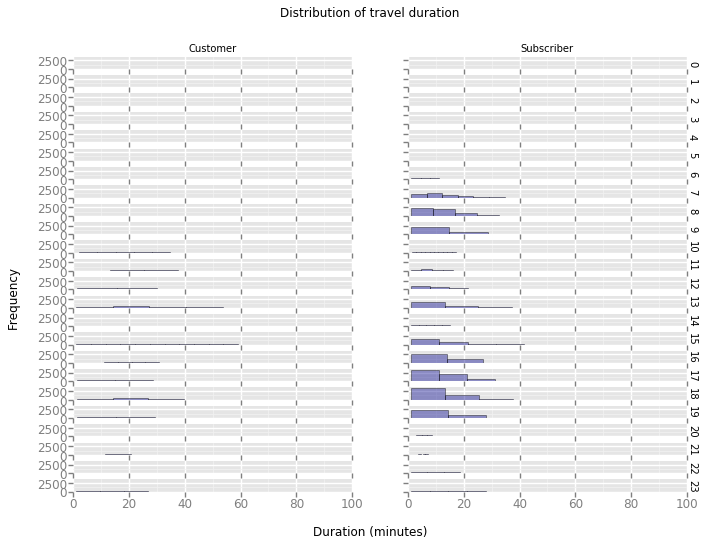

In [348]:
create_histogram('./data/Washington-2016-Summary.csv', facet=True, x_facet='hour', y_facet='user_type', x_axis_limit=100)

#### Faceting by day (sorted)

By changing the facet setting to month, it is also possible to see that the subcribers tend to use the service around rush hour which backs up my previous hypothesis that subscribers tend to use the service around rush hour, whereas customers tend to use it regularly throughout the day.

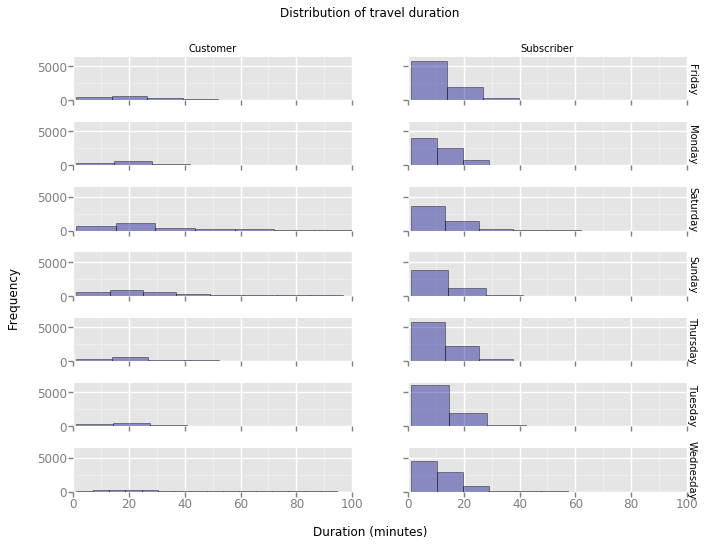

In [349]:
create_histogram('./data/Washington-2016-Summary.csv', facet=True, x_facet='day_of_week', y_facet='user_type', x_axis_limit=100)

I can't find a way to stop ggplot from plotting the days as strings and sorting them accordingly. I tried converting the df to numbers but it's just not working for some reason.

In any case, subscribers tend to use the bikeshare service throughout the week whereas customers only really use it on the weekends. This suggests that subcribers tend to use the bikeshare service because they have a vested interest in it wheras customers will only use it when they are doing things that are less routine.

Overall, I would say that the shape of each distribution looks very similar to a normal distribution with some variances being rather wide and some means being very close to 0. (If you increase the granularity of the data you'll see that there is a right skew because of outliers using the bikeshare system for long amounts of time.)

### 4.3 - Calculating Subscriber:Customer ratio through the year

Finally, I just want to see what the subscriber:customer ratio looks like throughout the year. It is possible to get a feel for this by looking at the plots in §4.2, the facets in that section are very informative and fives a quick and intuitive feel for the data in my opinion but I just wanted to take this extra step further just to make sure it is done.

The steps I will take will be to make a dictionary that contains each month as a key and then each value will be the calculated ratio.

I will then convert this dictionary to a dataframe using pandas and then create a bar chart using ggplot.

In [370]:
def calculate_subscriber_ratio(path):
    """
    This function calculates the subscriber:customer ratio for each month within a CSV file,
    returns a dictionary.
    """
    
    # import dataframe
    df = pd.read_csv(path)
    
    # create empty dictionary
    dict_for_df = {'month': [],
                   'sub_cust_ratio': []}
    
    # fill dictionary with values
    for month in range(12):
        month+=1
        df2 = df[df['month']==month]
        customers_Month = len(df2[df2['user_type']=='Customer'])
        subscribers_Month = len(df2[df2['user_type']=='Subscriber'])
        dict_for_df['month'].append(month)
        dict_for_df['sub_cust_ratio'].append(subscribers_Month/customers_Month)        
    return dict_for_df
    
# Test function
print(calculate_subscriber_ratio('./data/Washington-2016-Summary.csv'))

{'month': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'sub_cust_ratio': [9.963963963963964, 9.084805653710248, 3.6885521885521886, 3.6996644295302015, 3.621794871794872, 3.288224956063269, 2.358188472095151, 2.985603543743079, 3.108721624850657, 3.353846153846154, 3.8502325581395347, 6.763888888888889]}


In [415]:
def create_barchart(dictionary):
    
    # Create Dataframe
    df = pd.DataFrame(dictionary)
    
    # Create plot
    %matplotlib inline
    plot = ggplot(aes(x='month', y='sub_cust_ratio'), data=df) +\
    geom_point(color='darkblue') +\
    xlab("Month") + ylab("Subscriber:Customer Ratio")+\
    ggtitle("Subscriber:Customer Ratio as a function of month")
    plot.show()

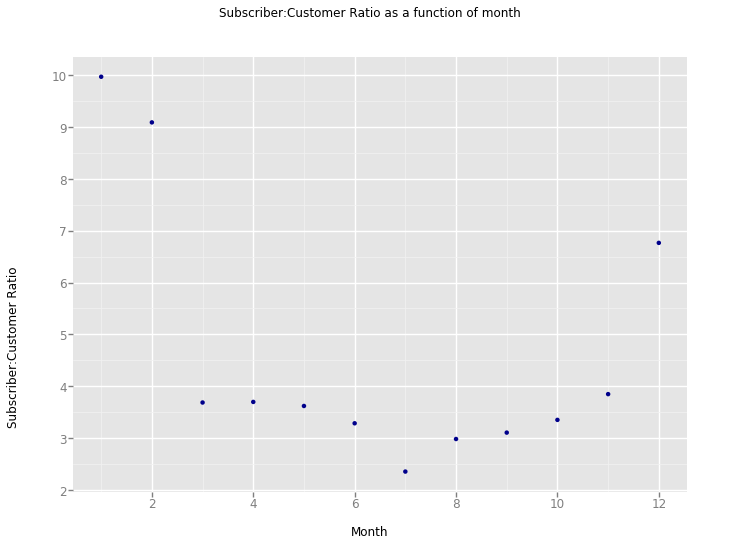

In [416]:
newdict = calculate_subscriber_ratio('./data/Washington-2016-Summary.csv')
create_barchart(newdict)

From the above plot it is evident that Subcribers tend to be more common users of the Bikeshare service, however, this membership spikes around nweyear. This is likely because as the new year approaches, subscribers are renewing their memberships.

Although most subscribers wait until after the newyear to buy their new subscription after it has expired, there are a couple of "early birds" who buy their memberships on december. 

## 5.0 Conclusion

It took a while to work through everything but the data really did reveal a lot of things which are relevant in a business setting.

Most of my questions required more complicated analysis such as trying to use geographic locations to optimize the location of bikeshare stations, they were a little too abitious for this analysis.

This analysis came to the following conclusions:
* NYC has the highest number of subscribers and total users
* The average travel time is roughly 15 minutes
* There are a couple of outliers where people rent the bike for days at a time.
* Most customers are subscribers (80%)
* Customers ride their bikes for longer times than Subscribers
* Subscribers and Customers use the bikes most during holidays (Summer, Christmas)
* Subscribers will use their bikes during rush hour
* Customers use bikes ar their own leisure
* Customers prefer to ride on the weekend
* Subscribers use their bikes consistently through the week
* Subscribers renew their memberships around new-year

This is actually quite a lot of finding consider that the data that we used wasn't incredibly extensive. It really shows howm much the data speaks when you take the time to get to know it.

#### Where do I want to use these skills?

I personally want to use these skills to analyze open data that can be found on the internet. There are all sorts of things such as social media sentiment, economic data from the World Bank/OECD or on wellbeing (UNICEF)